In [1]:
# Import common modules and set global configs
from project_utils.common_imports import *

# Specific imports for data, augmentation, model, and evaluation
from project_utils.loading_utils import main_data_processing_pipeline
from project_utils.data_augmentor_and_generator import data_generator
from project_utils.model_architect import get_vit_model, macro_f1_fn, categorical_focal_loss, UnfreezeBackbone, get_cosine_decay_scheduler
from project_utils.evaluation_utils import evaluate_on_test, plot_training_diagnostics, plot_test_evaluation, CLASS_MAPPING_DICT

# System info
print(f"TensorFlow version: {tf.__version__}")
print(f"GPUs available: {len(tf.config.list_physical_devices('GPU'))}")

2025-08-04 12:33:06.858548: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-04 12:33:06.873419: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754335986.889576 1236335 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754335986.894337 1236335 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754335986.905839 1236335 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

TensorFlow version: 2.19.0
GPUs available: 1


In [ ]:
class CFG:
    # ─── Static defaults ────────────────────────────────────────────────────────
    seed = 42
    debug = False
    print_freq = 10000
    num_workers = 1

    # Parametric settings
    model_type = "rescnn" # vit or rescnn
    input_dim = 256             # can be 32, 64, 256, etc.
    use_augmentation   = False
    use_oversampling   = False
    use_class_weights  = False
    use_transfer_learning = False

    # Training hyperparams
    epochs       = 10
    batch_size   = 16
    lr           = 1e-4  # Updated: Start learning rate at 1e-3
    weight_decay = 1e-5
    min_lr       = 1e-6

    # Cross-validation
    n_fold         = 4
    selected_folds = [0, 1, 2, 3]

    # Model / data specifics
    in_channels = 1
    num_classes = 4
    freeze_epochs = 0

    # Augmentation params (adjusted dynamically below)
    noise_std      = 0.1
    max_time_shift = 0.2
    max_freq_shift = 0.2
    max_mask_time  = 0.15
    max_mask_freq  = 0.15

    # ─── Paths ───────────────────────────────────────────────────────────────────
    PROJECT_ROOT_DIR = Path.cwd().parents[2]
    OUTPUT_DIR       = PROJECT_ROOT_DIR / "data/working"
    SPECTROGRAMS_DIR = OUTPUT_DIR / "birdclef25-mel-spectrograms"

    working_df_path  = PROJECT_ROOT_DIR / "data/raw/downsampled_metadata.csv"

    MODELS_DIR     = OUTPUT_DIR / "models"
    PLOTS_DIR      = OUTPUT_DIR / "plots"
    RESULTS_CSV_DIR= OUTPUT_DIR / "result_csvs"

    # ─── Initialization ──────────────────────────────────────────────────────────
    def __init__(self):

        # Minimal seed setting
        os.environ['PYTHONHASHSEED'] = str(self.seed)  # For hash consistency (e.g., dict ordering)
        random.seed(self.seed)                         # Python random
        np.random.seed(self.seed)                      # NumPy random
        tf.random.set_seed(self.seed)                  # TensorFlow/Keras global seed

        # 1) Create dirs
        for d in (self.MODELS_DIR, self.PLOTS_DIR, self.RESULTS_CSV_DIR):
            os.makedirs(d, exist_ok=True)

        # 2) Fix augmentation-dependent params
        if self.use_augmentation:
            self.aug_prob    = 1
            self.mixup_alpha = 0.2

            # Set size-specific augmentation params
            if self.input_dim == 32:
                self.noise_std      = 0.065
                self.max_time_shift = 0.11
                self.max_freq_shift = 0.065
                self.max_mask_time  = 0.125
                self.max_mask_freq  = 0.1
            elif self.input_dim == 64:
                self.noise_std      = 0.09
                self.max_time_shift = 0.135
                self.max_freq_shift = 0.09
                self.max_mask_time  = 0.175
                self.max_mask_freq  = 0.135
            else:
                # Fallback for other sizes (e.g., 256); use 64x64 values
                self.noise_std      = 0.09
                self.max_time_shift = 0.135
                self.max_freq_shift = 0.09
                self.max_mask_time  = 0.175
                self.max_mask_freq  = 0.135
        else:
            self.aug_prob    = 0.0
            self.mixup_alpha = 0.0

        # 3) Seed RNGs
        random.seed(self.seed)
        np.random.seed(self.seed)
        tf.random.set_seed(self.seed)

        # 4) Debug override
        if self.debug:
            self.epochs = 3
            self.selected_folds = [0]

    # ─── Derived properties ─────────────────────────────────────────────────────
    @property
    def spectrogram_npy(self):
        return self.SPECTROGRAMS_DIR / f"birdclef2025_melspec_5sec_{self.input_dim}_{self.input_dim}.npy"

    @property
    def TARGET_SHAPE(self):
        return (self.input_dim, self.input_dim)

    @property
    def model_save_name(self):
        suffix = ""
        if self.use_augmentation:      suffix += "_aug"
        if self.use_oversampling:      suffix += "_os"
        if self.use_class_weights:     suffix += "_cw"
        if self.use_transfer_learning: suffix += "_tl"
        if self.model_type.lower() == "vit":
            return f"vit_model_{self.input_dim}{suffix}.keras"
        elif self.model_type.lower() == "rescnn":
            return f"rescnn_model_{self.input_dim}{suffix}.keras"
        else:
            raise ValueError(f"Unsupported model type: {self.model_type}. Use 'vit' or 'rescnn'.")
    
cfg = CFG()

In [3]:
# Load pre-computed mel spectrograms
spectrograms = np.load(cfg.spectrogram_npy, allow_pickle=True).item()
print(f"Loaded {len(spectrograms)} pre-computed mel spectrograms")
print(f"Example spectrogram shape: {spectrograms['1139490-CSA36389'].shape}")

Loaded 28564 pre-computed mel spectrograms
Example spectrogram shape: (256, 256)


In [4]:
# Run the main pipeline to load data, compute factors/weights, and inspect
combined_train_val_df, test_df, class_weights_dict, filtered_spectrograms = main_data_processing_pipeline(
    cfg, spectrograms, data_generator
)

# For generator usage
class_weights = class_weights_dict if cfg.use_class_weights else None
combined_train_val_df.head(3)  # Display first 3 rows for inspection

# Manage memory usage
del spectrograms
gc.collect()


Loading full dataset...
Train/Val samples: 332
Test samples: 68
Filtered spectrograms to 400 entries
Class counts in train/val: {0: 87, 1: 84, 2: 81, 3: 80}
Computed oversampling factors: {0: 1, 1: 1, 2: 1, 3: 1}

Full dataset class distribution:
 0: Amphibia - 87 samples (26.2%)
 1: Aves - 84 samples (25.3%)
 2: Insecta - 81 samples (24.4%)
 3: Mammalia - 80 samples (24.1%)
Imbalance ratio: Aves / Total = 25.30%

Using uniform class weights.
Final class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}

Inspecting one batch from the data generator:


I0000 00:00:1754335993.593110 1236335 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1058 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:e3:00.0, compute capability: 8.0


Batch shape: (256, 256, 1)
Example batch labels (one-hot): [1. 0. 0. 0.]
Class order: [Amphibia, Aves, Insecta, Mammalia]


26

In [5]:
# Stratified 80-20 split on combined_train_val_df
train_df, val_df = train_test_split(
    combined_train_val_df, 
    test_size=0.2, 
    stratify=combined_train_val_df['y_species_encoded'],  # Assuming 'label' is the class column; adjust if needed
    random_state=cfg.seed
)

print(f"Train samples after split: {len(train_df)}")
print(f"Validation samples after split: {len(val_df)}")

# Build the model
model = get_vit_model(cfg)
# model.summary()

print(f'The model will be saved as: \n\t\t{cfg.model_save_name}')

Train samples after split: 265
Validation samples after split: 67


2025-08-04 12:33:13.827012: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


The model will be saved as: 
		rescnn_model_256.keras


In [6]:
# Get Cosine Decay scheduler
cosine_scheduler = get_cosine_decay_scheduler(train_df, cfg)

model.compile(
    optimizer = keras.optimizers.AdamW(
        learning_rate=cosine_scheduler,  # Use scheduler instead of fixed lr
        weight_decay=cfg.weight_decay
    ),
    loss      = "categorical_crossentropy",  # Or categorical_focal_loss() as before
    metrics   = [
        "accuracy",
        macro_f1_fn,
        metrics.AUC(name="auroc", multi_label=True, from_logits=False)
    ],
)

os.makedirs('./logs', exist_ok=True)

# Callbacks (early stopping, checkpoint, unfreeze)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(cfg.MODELS_DIR / cfg.model_save_name, save_best_only=True),
    # TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, update_freq='epoch'),
]

if cfg.use_transfer_learning:
    if cfg.model_type.lower() == "vit":
        callbacks.append(
            UnfreezeBackbone(freeze_epochs=cfg.freeze_epochs, key="vi_t_backbone"),
        )
    elif cfg.model_type.lower() == "rescnn":
        callbacks.append(
            UnfreezeBackbone(freeze_epochs=cfg.freeze_epochs, key="efficient_net"),
        )


train_ds = tf.data.Dataset.from_generator(
    lambda: data_generator(train_df, cfg, filtered_spectrograms, class_weights, is_train=True, yield_weight=cfg.use_class_weights),
    output_signature=(
        tf.TensorSpec(shape=(*cfg.TARGET_SHAPE, cfg.in_channels), dtype=tf.float32),
        tf.TensorSpec(shape=(cfg.num_classes,), dtype=tf.float32)
    ) if not cfg.use_class_weights else (
        tf.TensorSpec(shape=(*cfg.TARGET_SHAPE, cfg.in_channels), dtype=tf.float32),
        tf.TensorSpec(shape=(cfg.num_classes,), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(cfg.batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_generator(
    lambda: data_generator(val_df, cfg, filtered_spectrograms, class_weights, is_train=False, yield_weight=cfg.use_class_weights),
    output_signature=(
        tf.TensorSpec(shape=(*cfg.TARGET_SHAPE, cfg.in_channels), dtype=tf.float32),
        tf.TensorSpec(shape=(cfg.num_classes,), dtype=tf.float32)
    ) if not cfg.use_class_weights else (
        tf.TensorSpec(shape=(*cfg.TARGET_SHAPE, cfg.in_channels), dtype=tf.float32),
        tf.TensorSpec(shape=(cfg.num_classes,), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(cfg.batch_size).prefetch(tf.data.AUTOTUNE)

# Train the model (pass datasets instead of raw generators)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=cfg.epochs,
    callbacks=callbacks,
    class_weight=class_weights if cfg.use_class_weights else None,
    verbose=1
)

Epoch 1/10


I0000 00:00:1754335997.828261 1236383 service.cc:152] XLA service 0x7f0bd402a1b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754335997.828288 1236383 service.cc:160]   StreamExecutor device (0): NVIDIA A30, Compute Capability 8.0
2025-08-04 12:33:17.899271: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754335998.522160 1236383 cuda_dnn.cc:529] Loaded cuDNN version 90300


      7/Unknown 17s 27ms/step - accuracy: 0.2741 - auroc: 0.4988 - loss: 1.5988 - macro_f1_fn: 0.2199

I0000 00:00:1754336011.016154 1236383 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


     15/Unknown 17s 27ms/step - accuracy: 0.2643 - auroc: 0.4923 - loss: 1.6183 - macro_f1_fn: 0.2151

2025-08-04 12:33:37.307568: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv %cudnn-conv-bw-filter.9 = (f16[64,3,3,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[9,128,128,64]{3,2,1,0} %bitcast.12821, f16[9,128,128,64]{3,2,1,0} %bitcast.12823), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", metadata={op_type="Conv2DBackpropFilter" op_name="gradient_tape/functional_1/conv2d_2_1/convolution/Conv2DBackpropFilter" source_file="/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-08-04 12:33:37.346126: E external/local_xla/xla/service/slow_operation_alarm.

     17/Unknown 27s 687ms/step - accuracy: 0.2623 - auroc: 0.4912 - loss: 1.6188 - macro_f1_fn: 0.2146

2025-08-04 12:33:42.040207: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-04 12:33:42.040231: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-08-04 12:33:42.040247: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2799075806495025520
2025-08-04 12:33:42.040253: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8220728557266503482


17/17 ━━━━━━━━━━━━━━━━━━━━ 30s 877ms/step - accuracy: 0.2616 - auroc: 0.4908 - loss: 1.6190 - macro_f1_fn: 0.2147 - val_accuracy: 0.2388 - val_auroc: 0.4297 - val_loss: 1.3879 - val_macro_f1_fn: 0.0999
Epoch 2/10


2025-08-04 12:33:44.935387: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.1955 - auroc: 0.4912 - loss: 1.5242 - macro_f1_fn: 0.1799 - val_accuracy: 0.2388 - val_auroc: 0.5439 - val_loss: 1.3864 - val_macro_f1_fn: 0.0999
Epoch 3/10


2025-08-04 12:33:47.634007: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2697 - auroc: 0.5310 - loss: 1.5522 - macro_f1_fn: 0.2491

2025-08-04 12:33:50.633023: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2799075806495025520
2025-08-04 12:33:50.633043: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8220728557266503482
2025-08-04 12:33:50.734079: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2799075806495025520
2025-08-04 12:33:50.734099: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8220728557266503482


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.2687 - auroc: 0.5320 - loss: 1.5483 - macro_f1_fn: 0.2473 - val_accuracy: 0.2537 - val_auroc: 0.5765 - val_loss: 1.3844 - val_macro_f1_fn: 0.1772
Epoch 4/10
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3419 - auroc: 0.5763 - loss: 1.4548 - macro_f1_fn: 0.3059

2025-08-04 12:33:51.881134: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2799075806495025520
2025-08-04 12:33:51.881167: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8220728557266503482
2025-08-04 12:33:51.980131: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-08-04 12:33:51.980158: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2799075806495025520
2025-08-04 12:33:51.980168: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8220728557266503482


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3377 - auroc: 0.5764 - loss: 1.4512 - macro_f1_fn: 0.3030 - val_accuracy: 0.3433 - val_auroc: 0.5844 - val_loss: 1.3830 - val_macro_f1_fn: 0.2610
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2563 - auroc: 0.5345 - loss: 1.4724 - macro_f1_fn: 0.2198 - val_accuracy: 0.3134 - val_auroc: 0.5822 - val_loss: 1.3835 - val_macro_f1_fn: 0.1826
Epoch 6/10
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.0625 - auroc: 0.6116 - loss: 1.3519 - macro_f1_fn: 0.0500

2025-08-04 12:33:52.515201: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2799075806495025520
2025-08-04 12:33:52.515224: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8220728557266503482
2025-08-04 12:33:52.614451: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2799075806495025520
2025-08-04 12:33:52.614470: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8220728557266503482


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3065 - auroc: 0.6134 - loss: 1.3692 - macro_f1_fn: 0.2688 - val_accuracy: 0.2687 - val_auroc: 0.6049 - val_loss: 1.3853 - val_macro_f1_fn: 0.1257
Epoch 7/10
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2981 - auroc: 0.5933 - loss: 1.3799 - macro_f1_fn: 0.2609

2025-08-04 12:33:53.242845: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2799075806495025520
2025-08-04 12:33:53.242872: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8220728557266503482


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2961 - auroc: 0.5858 - loss: 1.4051 - macro_f1_fn: 0.2670 - val_accuracy: 0.2537 - val_auroc: 0.5909 - val_loss: 1.3872 - val_macro_f1_fn: 0.1030
Epoch 8/10
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3546 - auroc: 0.5850 - loss: 1.3675 - macro_f1_fn: 0.3470

2025-08-04 12:33:53.757986: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2799075806495025520
2025-08-04 12:33:53.758012: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8220728557266503482


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3535 - auroc: 0.5978 - loss: 1.3670 - macro_f1_fn: 0.3455 - val_accuracy: 0.2537 - val_auroc: 0.5938 - val_loss: 1.3905 - val_macro_f1_fn: 0.1030
Epoch 9/10
 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4401 - auroc: 0.6324 - loss: 1.3527 - macro_f1_fn: 0.4031

2025-08-04 12:33:54.385658: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-08-04 12:33:54.385684: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2799075806495025520
2025-08-04 12:33:54.385692: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8220728557266503482


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.3972 - auroc: 0.6234 - loss: 1.3620 - macro_f1_fn: 0.3670 - val_accuracy: 0.2537 - val_auroc: 0.6145 - val_loss: 1.3946 - val_macro_f1_fn: 0.1030


2025-08-04 12:33:54.797717: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2799075806495025520
2025-08-04 12:33:54.797750: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8220728557266503482
2025-08-04 12:33:54.894258: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2799075806495025520
2025-08-04 12:33:54.894277: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8220728557266503482


In [7]:
# Evaluate on test set
y_true, y_pred_prob = evaluate_on_test(model, cfg, filtered_spectrograms, test_df)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step

Test Loss: 1.3886
Test AUC: 0.4966
Test Accuracy: 0.2353


Training curves saved to: /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/plots/training_curves_256rescnn_model_256.png


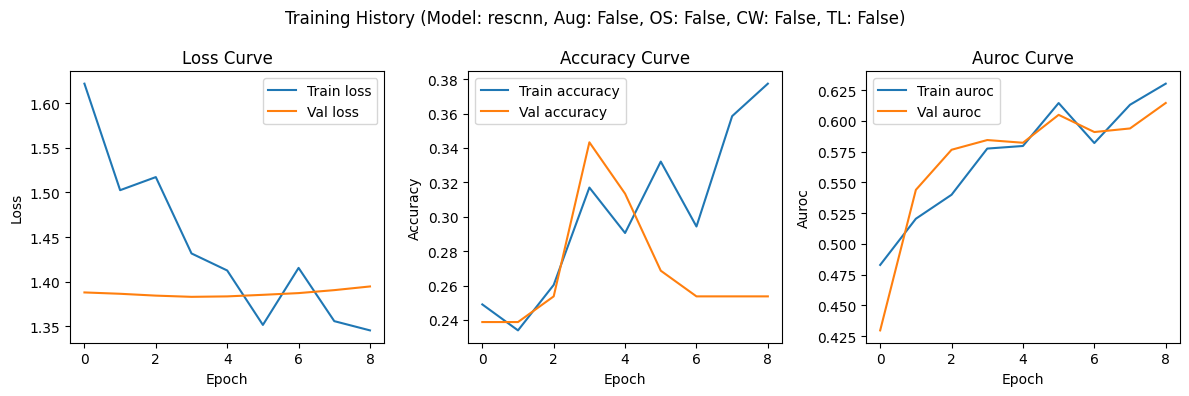

Confusion matrix saved to: /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/plots/confusion_matrix_256rescnn_model_256.png


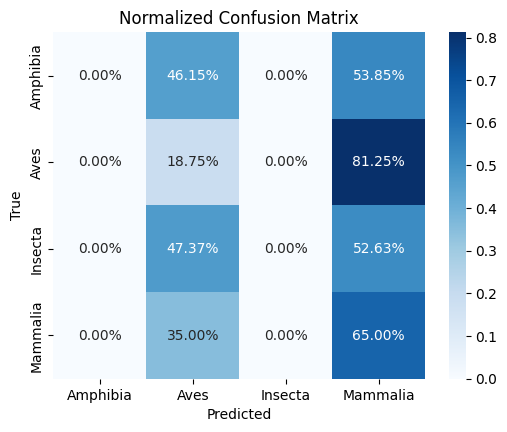

Per-class metrics saved to: /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/plots/per_class_metrics_256rescnn_model_256.png


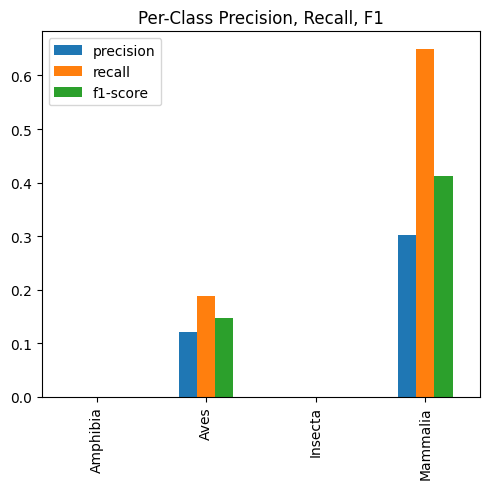

Test evaluation plot saved to: /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/plots/test_evaluation_256rescnn_model_256.png


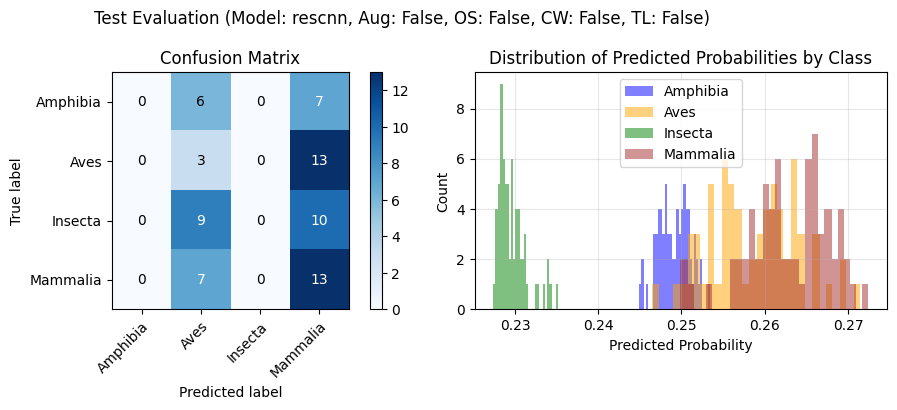

Classification report saved to: /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/result_csvs/classification_report_256rescnn_model_256.csv

Classification Report:
              precision    recall  f1-score   support

    Amphibia       0.00      0.00      0.00        13
        Aves       0.12      0.19      0.15        16
     Insecta       0.00      0.00      0.00        19
    Mammalia       0.30      0.65      0.41        20

    accuracy                           0.24        68
   macro avg       0.11      0.21      0.14        68
weighted avg       0.12      0.24      0.16        68



In [8]:
# Plot training diagnostics
plot_training_diagnostics(history, cfg,  y_true, y_pred_prob, CLASS_MAPPING_DICT)

# Plot test evaluation (confusion matrix, report)
plot_test_evaluation(y_true, y_pred_prob, class_mapping=CLASS_MAPPING_DICT, cfg=cfg)